In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/232E-SocialNetworks/Project2/

[Errno 2] No such file or directory: 'drive/MyDrive/232E-SocialNetworks/Project2/'
/content/drive/MyDrive/232E-SocialNetworks/Project2


# IMPORTS

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
from typing import Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from typing_extensions import Literal, TypedDict

%matplotlib inline

# DATASET

In [ ]:
cora_dataset = Planetoid("/tmp/Cora", name = "Cora")

In [ ]:
num_nodes = cora_dataset.data.num_nodes
num_edges = cora_dataset.data.num_edges // 2
num_classes = cora_dataset.num_classes
num_features = cora_dataset.num_node_features

train_len = cora_dataset[0].train_mask.sum()
validation_len = cora_dataset[0].val_mask.sum()
test_len = cora_dataset[0].test_mask.sum()

print("Number of nodes (ML documents): ", num_nodes)
print("Number of edges: ", num_edges)
print("Number of classes: ", num_classes)
print("Number of features per node: ", num_features)

Number of nodes (ML documents):  2708
Number of edges:  5278
Number of classes:  7
Number of features per node:  1433


# GRAPH CONVOLUTIONAL NETWORK MODEL

In [ ]:
class GraphConvolutionalNetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = GCNConv(hidden_dim, 32)
        self.conv3 = GCNConv(32, num_classes)

    def forward(self, x, edge_index):
        x = self.dropout(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# TRAINING AND VALIDATION

TRAIN_STEP FUNCTION

In [ ]:
def train_step(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim = 1)
    y = data.y[mask]
    loss = loss_fn(logits, y)

    accuracy = (preds == y).sum().item() / y.numel()
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy

VALIDATION_STEP FUNCTION

In [ ]:
@torch.no_grad()
def eval_step(model, data, loss_fn, stage):
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)

    accuracy = (preds == y).sum().item() / y.numel()
    return loss.item(), accuracy

TRAINING AND VALIDATION WRAPPER FUNCTION

In [ ]:
def train(model, data, optimizer, loss_fn = torch.nn.CrossEntropyLoss(), max_epochs = 200, early_stopping = 10, print_interval = 1, verbose = True):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(max_epochs):
        train_loss, train_acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly Stopping...")
            break
        
        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
    
    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    return history

In [ ]:
SEED = 42
MAX_EPOCHS = 300
LEARNING_RATE = 0.001
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10
HIDDEN_DIM = 16
DROPOUT = 0.5

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphConvolutionalNetwork(num_features, num_classes, HIDDEN_DIM, DROPOUT).to(device)
data = cora_dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs = MAX_EPOCHS, early_stopping = EARLY_STOPPING)


Epoch: 0
----------
Train Loss: 2.7580 | Train acc: 0.1357
  Val Loss: 2.7645 |   Val acc: 0.0800

Epoch: 1
----------
Train Loss: 2.7585 | Train acc: 0.1214
  Val Loss: 2.7568 |   Val acc: 0.0840

Epoch: 2
----------
Train Loss: 2.7446 | Train acc: 0.1786
  Val Loss: 2.7492 |   Val acc: 0.0880

Epoch: 3
----------
Train Loss: 2.7368 | Train acc: 0.1500
  Val Loss: 2.7416 |   Val acc: 0.0860

Epoch: 4
----------
Train Loss: 2.7270 | Train acc: 0.1286
  Val Loss: 2.7340 |   Val acc: 0.0860

Epoch: 5
----------
Train Loss: 2.7180 | Train acc: 0.1429
  Val Loss: 2.7261 |   Val acc: 0.0880

Epoch: 6
----------
Train Loss: 2.7117 | Train acc: 0.1429
  Val Loss: 2.7179 |   Val acc: 0.0960

Epoch: 7
----------
Train Loss: 2.6827 | Train acc: 0.2357
  Val Loss: 2.7093 |   Val acc: 0.1040

Epoch: 8
----------
Train Loss: 2.6767 | Train acc: 0.1929
  Val Loss: 2.7002 |   Val acc: 0.1080

Epoch: 9
----------
Train Loss: 2.6850 | Train acc: 0.1643
  Val Loss: 2.6907 |   Val acc: 0.1140

Epoch: 10

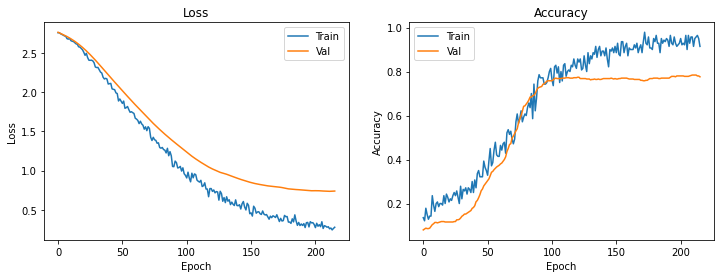

In [ ]:
def plot_history(history):
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["train_loss"], label = "Train")
    ax1.plot(history["val_loss"], label = "Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["train_acc"], label = "Train")
    ax2.plot(history["val_acc"], label = "Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    ax2.legend()

plt.figure(figsize=(12, 4))
plot_history(history)